# Setup

In [1]:
DATA_FILE_NAME = "consultation-documents-preprocessed-2025-01-06.parquet"

LANGUAGES = {
    "de",
    # "fr",
    # "it",
}

# EMBEDDING_MODEL = "openai/text-embedding-ada-002"
EMBEDDING_MODEL = "openai/text-embedding-3-large"

# FROM_YEAR = 2010
FROM_YEAR = 2000

MERGE_CLASSES = {
    # (classes, to, drop): replacement_class
    # ("RESPONSE_FORM", "SURVEY", "SYNOPTIC_TABLE", "VARIOUS_TEXT"): "VARIOUS_TEXT",
}

INCLUDE_RULE_LABELS_IN_TRAINING = {
    # "REPORT",
    "SYNOPTIC_TABLE",
    "LETTER",
}

CV_FOLDS = 5
TEST_SIZE = 0.1
RANDOM_STATE = 2718
USE_TEST_SET = False

%env MLFLOW_TRACKING_URI=sqlite:///mlruns.db

env: MLFLOW_TRACKING_URI=sqlite:///mlruns.db


In [2]:
%load_ext autoreload
%autoreload 2

import logging
import pathlib
import sys
from typing import Any

import dotenv
import mlflow
import numpy as np
import pandas as pd
import sklearn.metrics
import sklearn.model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from tqdm import tqdm

REPOSITORY_ROOT = (pathlib.Path().cwd() / ".." / "..").resolve()
sys.path.append(str(REPOSITORY_ROOT))

In [3]:
from research.document_types import document_title_rule_model
from research.lib import data_access, embeddings, plotting

In [4]:
dotenv.load_dotenv()

True

In [5]:
mlflow.set_experiment(f"V1. {'&'.join(sorted(LANGUAGES))}. document types")

if run := mlflow.active_run():
    logging.warning("Run = %s is already active, closing it.", run.info.run_name)
    mlflow.end_run()
run = mlflow.start_run()
print("Starting run:", run.info.run_name)
mlflow.log_param("input_file", DATA_FILE_NAME)
mlflow.log_param("languages", LANGUAGES)
mlflow.log_param("from_year", FROM_YEAR)
mlflow.log_param("embedding_model", EMBEDDING_MODEL)
mlflow.log_param("cv_folds", CV_FOLDS)
mlflow.log_param("test_size", TEST_SIZE)
mlflow.log_param("random_state", RANDOM_STATE)
;

Starting run: fun-deer-165


''

In [6]:
mlflow.sklearn.autolog()
tqdm.pandas()

2025/01/27 15:36:10 WARNING mlflow.utils.autologging_utils: MLflow sklearn autologging is known to be compatible with 0.24.1 <= scikit-learn <= 1.5.2, but the installed version is 1.6.0. If you encounter errors during autologging, try upgrading / downgrading scikit-learn to a compatible version, or try upgrading MLflow.


# Input data preparation

In [7]:
def merge_classes(series: pd.Series) -> pd.Series:
    """Apply the MERGE_CLASSES setting to a series of document type labels."""
    series = series.copy()
    for old_classes, new_class in MERGE_CLASSES.items():
        mask = series.isin(old_classes)
        series.loc[mask] = new_class
    return series

In [8]:
PREPROCESSED_DATA_FILE = REPOSITORY_ROOT / "data" / "dataframes" / DATA_FILE_NAME
data_access.ensure_dataframe_is_available(PREPROCESSED_DATA_FILE)

## Load Fedlex data (all of it is used for training)

In [9]:
df_fedlex = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"fedlex"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_fedlex

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
0,1,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",DRAFT,de,Vernehmlassungsvorlage,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,«$$e-seal» \n«$$QrCode» \n \n2021-… \n«%ASFF_Y...
3,4,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",RECIPIENT_LIST,de,Adressatenliste,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
6,7,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 2,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
9,10,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",REPORT,de,Erläuternder Bericht,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,1. Oktober 2021 \n \n \n \n \nVerordnung des B...
12,13,1,2021-10-01,2022-01-17,Verordnung des BAZG über die Bekämpfung von G...,Mit der am 19. März 2021 durch das Parlament b...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/7bt3hz2w,"[administration, finance, security]",LETTER,de,Begleitschreiben 1,41,Bundesamt für Zoll und Grenzsicherheit,ch,2024-11-04 15:11:24,fedlex,manual,Eidgenössisches Finanzdepartement EFD \nEidgen...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52027,53636,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52030,53639,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",LETTER,de,Begleitschreiben-2,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,Schweizerische Eidgenossenschaft\nConfëdëratio...
52033,53642,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https://www.demokratis.ch/vernehmlassung/2b64exk2,"[energy, spatial_planning]",REPORT,de,Erläuternder Bericht,44,Bundesamt für Energie,ch,2024-11-05 11:39:50,fedlex,manual,BFE-D-BDD93401/157\n \nEidgenössisches Departe...
52036,53645,4940,2024-12-20,2025-04-03,Indirekter Gegenvorschlag (Änderung des Kernen...,Das Verbot des Erteilens der Rahmenbewilligung...,https://fedlex.data.admin.ch/filestore/fedlex....,https:/

## Load OpenParlData and generate labels by the rule model

In [10]:
df_opd = data_access.load_consultation_documents(
    PREPROCESSED_DATA_FILE,
    only_document_sources={"openparldata"},
    only_languages=LANGUAGES,
    starting_year=FROM_YEAR,
    mlflow=mlflow,
)
df_opd

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: Failed to determine whether UCVolumeDatasetSource can resolve source information for '/Users/vita/Code/demokratis/demokratis-ml/data/dataframes/consultation-documents-preprocessed-2025-01-06.parquet'. Exception: 
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/data/dataset_source_registry.py:149: UserWarning: The specified dataset source can be interpreted in multiple ways: LocalArtifactDatasetSource, LocalArtifactDatasetSource. MLflow will assume that this is a LocalArtifactDatasetSource source.
  return _dataset_source_registry.resolve(
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/mlflow/types/utils.py:407: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input da

,document_id,consultation_id,consultation_start_date,consultation_end_date,consultation_title,consultation_description,document_source_url,consultation_url,consultation_topics,document_type,document_language,document_title,organisation_id,organisation_name,political_body,consultation_reviewed_at,document_source,consultation_topics_label_source,document_content_plain
38324,38325,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 1 zum Anhörungsbericht (Statuten) (PDF...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Beilage 1 \nVerabschiedet durch Politisches Gr...
38325,38326,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 2 zum Anhörungsbericht (Aktionärbindun...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,"Stand: 20. November 2018, mit formalen Ergänzu..."
38326,38327,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 3 zum Anhörungsbericht (Eignerstrategi...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,Seite 1 von 2 Stand: 20. November 2018 \n\nEig...
38327,38328,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,Beilage 4 zum Anhörungsbericht (NOK-Gründungsv...,141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,731.120\n\nSchaffhauser Rechtsbuch 1997 1\n\nV...
38328,38329,2283,2019-05-09,2019-08-12,Auflösung NOK-Gründungsvertrag; Energiegesetz ...,,https://www.ag.ch/media/kanton-aargau/portal/a...,https://www.demokratis.ch/vernehmlassung/5cckh63y,"[economics, energy]",NaN,de,"Anhörungsbericht (PDF, 10 Seiten, 184 KB)",141,Regierungsrat des Kantons Aargau,ag,NaT,openparldata,openparldata,J:\03_Geschäfte\1_Vorträge\05_AE\Auflösung NOK...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52007,53616,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Bericht Sonderpädagogik der St.Galler Volksschule,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,Kanton St.Gallen \nBildungsdepartement \n \nAm...
52008,53617,4991,2024-12-18,2025-02-20,Bericht «Sonderpädagogik der St.Galler Volkssc...,Die Regierung des Kantons St.Gallen hat an ihr...,https://www.sg.ch/news/sgch_allgemein/2024/12/...,https://www.demokratis.ch/vernehmlassung/4tpw3ygc,[education],VARIOUS_TEXT,de,Anhang 1: Bericht der Paedagogischen Hochschul...,156,Regierung des Kantons St. Gallen,sg,NaT,openparldata,openparldata,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...
52039,53648,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Einladungsschreiben,150,Regierung des Kantons Graubünden,gr,NaT,openparldata,openparldata,"info@ekud.gr.ch \nwww.ekud.gr.ch\nErziehungs-,..."
52040,53649,4994,2024-12-19,2025-03-19,Vernehmlassung zum Erlass eines Gesetzes über ...,Die Bündner Regierung hat im Rahmen der Teilre...,https://www.gr.ch/DE/publikationen/vernehmlass...,https://www.demokratis.ch/vernehmlassung/v3tefzb7,[education],VARIOUS_TEXT,de,Erlass,150,Regierung des Kantons Graubünden,gr,NaT,openparlda

In [11]:
df_fedlex["document_type"].value_counts()

document_type
LETTER            3084
DRAFT             2898
REPORT            2153
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
VARIOUS_TEXT       418
SYNOPTIC_TABLE      81
SURVEY              13
RESPONSE_FORM        7
DECISION             0
LINK                 0
Name: count, dtype: int64

In [12]:
document_title_rule_model.predict(df_opd).value_counts(dropna=False)

document_type
None              3215
LETTER            1553
REPORT            1268
DRAFT             1255
VARIOUS_TEXT       852
SYNOPTIC_TABLE     708
RECIPIENT_LIST     623
SURVEY             264
FINAL_REPORT        88
RESPONSE_FORM       25
Name: count, dtype: int64

In [13]:
# Generate rule-labels (predictions)
df_opd["prediction_rule"] = document_title_rule_model.predict(df_opd)

# Split OpenParlData: only pick certain rule-labels for training. The rest will be used for testing.
opd_train_index = df_opd["prediction_rule"].isin(INCLUDE_RULE_LABELS_IN_TRAINING)
df_opd_train = df_opd.loc[opd_train_index].copy()
df_opd_test = df_opd.loc[~opd_train_index].copy()
del df_opd  # Prevent mistakes; we should only explicitly access the train or the test set from now on.

# Normalise the training portion: use the rule-label as the canonical target label.
del df_opd_train["document_type"]
df_opd_train = df_opd_train.rename(columns={"prediction_rule": "document_type"})

print(f"Adding {len(df_opd_train)} OpenParlData documents to the training set:")
df_opd_train["document_type"].value_counts(dropna=False)

Adding 2261 OpenParlData documents to the training set:


document_type
LETTER            1553
SYNOPTIC_TABLE     708
Name: count, dtype: int64

## Create the input dataframe from Fedlex and a part of OpenParlData

In [14]:
df_input = pd.concat([df_fedlex, df_opd_train], ignore_index=True)

In [15]:
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4637
DRAFT             2898
REPORT            2153
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
SYNOPTIC_TABLE     789
VARIOUS_TEXT       418
SURVEY              13
RESPONSE_FORM        7
Name: count, dtype: int64

## Merge classes

In [16]:
df_input["document_type"] = merge_classes(df_input["document_type"])
df_input["document_type"].value_counts(dropna=False)

document_type
LETTER            4637
DRAFT             2898
REPORT            2153
RECIPIENT_LIST    1770
FINAL_REPORT      1747
OPINION            985
SYNOPTIC_TABLE     789
VARIOUS_TEXT       418
SURVEY              13
RESPONSE_FORM        7
Name: count, dtype: int64

## Define the target

In [17]:
y_encoder = OrdinalEncoder(dtype=int)
df_input["document_type_code"] = y_encoder.fit_transform(df_input[["document_type"]])

## Drop empty documents

In [18]:
empty_index = df_input["document_content_plain"].str.strip() == ""
empty_count = len(df_input[empty_index])
print(f"Empty texts: {empty_count} ({100 * empty_count / len(df_input):.1f}%)")

Empty texts: 996 (6.5%)


In [19]:
df_input = df_input.loc[~empty_index]

## Splits

### Set aside a test set

In [20]:
splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_index, test_index = next(splitter.split(X=df_input, y=df_input["document_type_code"]))

In [21]:
df_input_train = df_input.iloc[train_index]
df_input_test = df_input.iloc[test_index]

print("Train:", df_input_train.shape)
print("Test:", df_input_test.shape)

Train: (12978, 20)
Test: (1443, 20)


In [22]:
mlflow.log_param("train_samples_count", len(df_input_train))
mlflow.log_param("test_samples_count", len(df_input_test))

1443

### Prepare a cross-validation splitter

In [23]:
cv_splitter = sklearn.model_selection.StratifiedKFold(
    n_splits=CV_FOLDS,
    shuffle=True,
    random_state=RANDOM_STATE,
)

# Embeddings

## Tokenise and truncate to input window

In [24]:
embedding_model = embeddings.create_embedding_model(EMBEDDING_MODEL)
mlflow.log_param("embedding_model.max_input_tokens", embedding_model.max_input_tokens)

tokens_train = df_input_train["document_content_plain"].progress_map(embedding_model.tokenize)
tokens_test = df_input_test["document_content_plain"].progress_map(embedding_model.tokenize)

100%|██████████| 1443/1443 [00:04<00:00, 322.67it/s]


## Embed

In [25]:
with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=True,
) as get_embeddings:
    embeddings_train = get_embeddings(tokens_train.tolist())
    print(embeddings_train.shape)
    embeddings_test = get_embeddings(tokens_test.tolist())
    print(embeddings_test.shape)

Embedding (cached=12977, new=0): 100%|██████████| 12978/12978 [00:08<00:00, 1467.78it/s]


(12978, 3072)


Embedding (cached=1442, new=0): 100%|██████████| 1443/1443 [00:00<00:00, 1533.08it/s]

(1443, 3072)


# Classification

In [26]:
X_train = embeddings_train
X_test = embeddings_test
y_train = df_input_train["document_type_code"]
y_test = df_input_test["document_type_code"]

print("Train", X_train.shape, y_train.shape)
print("Test", X_test.shape, y_test.shape)

Train (12978, 3072) (12978,)
Test (1443, 3072) (1443,)


In [27]:
classifier = make_pipeline(
    StandardScaler(),
    # PCA(n_components=200, random_state=RANDOM_STATE),
    LogisticRegression(max_iter=1000),
)
classifier

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [28]:
if "pca" in classifier.named_steps:
    mlflow.log_param("pca_n_components", classifier.named_steps["pca"].get_params()["n_components"])

In [29]:
def explained_variance_scorer(pipeline: Pipeline, X: Any, y: Any = None) -> np.float64:
    try:
        pca = pipeline.named_steps["pca"]
    except KeyError:
        return np.nan
    explained_variance = np.sum(pca.explained_variance_ratio_)
    return explained_variance


scoring = {
    "precision": "precision_weighted",
    "recall": "recall_weighted",
    "f1": "f1_weighted",
    "pca_explained_variance": explained_variance_scorer,
}

scores_docs = sklearn.model_selection.cross_validate(
    classifier,
    X=X_train,
    y=y_train,
    cv=cv_splitter,
    scoring=scoring,
)
scores_docs

/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/vita/Code/demokratis/demokratis-ml/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'fit_time': array([1.17150688, 1.17477131, 1.08553219, 1.32725191, 1.02516913]),
 'score_time': array([0.03406501, 0.02309465, 0.02185702, 0.02506423, 0.02315879]),
 'test_precision': array([0.95261642, 0.96104029, 0.95503514, 0.95568168, 0.9531562 ]),
 'test_recall': array([0.95454545, 0.96224961, 0.95647149, 0.95645472, 0.95414258]),
 'test_f1': array([0.95337084, 0.96132164, 0.95544595, 0.95591519, 0.95360199]),
 'test_pca_explained_variance': array([nan, nan, nan, nan, nan])}

## Evaluation of the cross-validation

In [30]:
avg_scores_docs = {k: np.round(np.mean(v), 4) for k, v in scores_docs.items()}
mlflow.log_metrics({f"{k}_docs": v for k, v in avg_scores_docs.items() if k.startswith("test_")})

print("Per-document CV scores:")
print(f"Precision: {avg_scores_docs['test_precision']:.4f} (+/- {np.std(scores_docs['test_precision']):.4f})")
print(f"Recall:    {avg_scores_docs['test_recall']:.4f} (+/- {np.std(scores_docs['test_recall']):.4f})")
print(f"F1:        {avg_scores_docs['test_f1']:.4f} (+/- {np.std(scores_docs['test_f1']):.4f})")

Per-document CV scores:
Precision: 0.9555 (+/- 0.0030)
Recall:    0.9568 (+/- 0.0029)
F1:        0.9559 (+/- 0.0029)


### Use subsets of the training set to re-train and evaluate. This gives us a single model to run reports on. 

In [31]:
cv_test_splitter = sklearn.model_selection.StratifiedShuffleSplit(
    n_splits=1,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

cv_train_index, cv_test_index = next(cv_test_splitter.split(X=X_train, y=y_train))

X_cv_train = X_train[cv_train_index]
y_cv_train = y_train.iloc[cv_train_index]
X_cv_test = X_train[cv_test_index]
y_cv_test = y_train.iloc[cv_test_index]

In [32]:
classifier.fit(X_cv_train, y_cv_train)
cv_test_predictions = classifier.predict(X_cv_test)

2025/01/27 15:38:51 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/01/27 15:38:55 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


                precision    recall  f1-score   support

         DRAFT       0.93      0.94      0.93       259
  FINAL_REPORT       0.99      0.98      0.99       157
        LETTER       0.99      1.00      1.00       335
       OPINION       0.98      1.00      0.99        87
RECIPIENT_LIST       0.99      1.00      1.00       158
        REPORT       0.95      0.95      0.95       193
 RESPONSE_FORM       1.00      1.00      1.00         1
        SURVEY       1.00      1.00      1.00         1
SYNOPTIC_TABLE       0.97      0.89      0.93        70
  VARIOUS_TEXT       0.61      0.62      0.61        37

      accuracy                           0.96      1298
     macro avg       0.94      0.94      0.94      1298
  weighted avg       0.96      0.96      0.96      1298



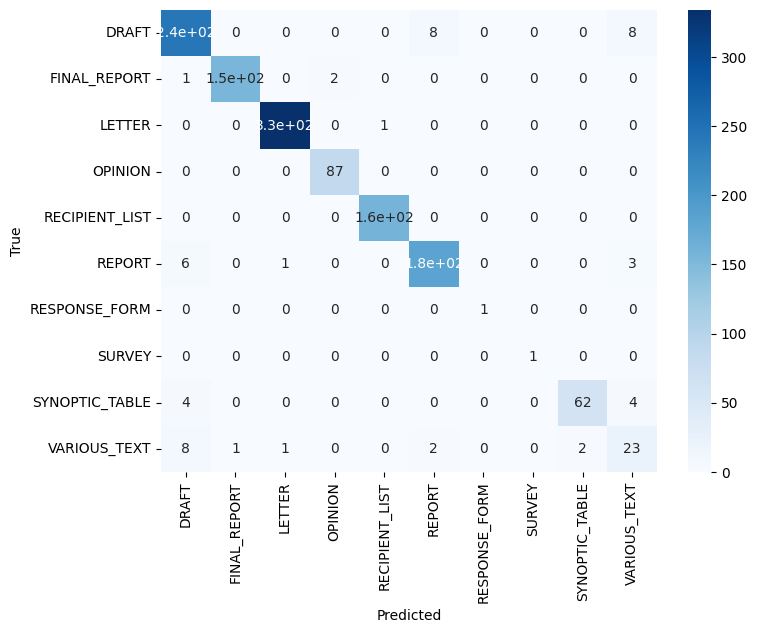

In [33]:
target_names = y_encoder.categories_[0]
print(
    sklearn.metrics.classification_report(
        y_cv_test,
        cv_test_predictions,
        target_names=target_names,
        labels=range(len(target_names)),
    )
)

display(plotting.plot_confusion_matrix_heatmap(y_cv_test, cv_test_predictions, target_names=target_names))

***

## Evaluation on the test set (USE SPARINGLY)

In [34]:
if USE_TEST_SET:
    classifier.fit(X_train, y_train)
    test_ground_truth_docs = y_test
    test_predictions_docs = classifier.predict(X_test)

    print("docs: ground truth", test_ground_truth_docs.shape)
    print("docs: predictions", test_predictions_docs.shape)

    print(
        sklearn.metrics.classification_report(
            test_ground_truth_docs,
            test_predictions_docs,
            target_names=y_encoder.categories_[0],
            labels=range(len(y_encoder.categories_[0])),
        )
    )

In [35]:
if USE_TEST_SET:
    display(
        plotting.plot_confusion_matrix_heatmap(
            test_ground_truth_docs, test_predictions_docs, target_names=y_encoder.categories_[0]
        )
    )

***

# Rule-based & ML model evaluation

## Embed the OpenParlData test set

In [36]:
tokens_opd_test = df_opd_test["document_content_plain"].progress_map(embedding_model.tokenize)

with embeddings.use_cache(
    embedding_model,
    tqdm=tqdm,
    cache_directory=REPOSITORY_ROOT / "data" / "embeddings-cache",
    read_only=True,
) as get_embeddings:
    embeddings_opd_test = get_embeddings(tokens_opd_test.tolist())
    print(embeddings_opd_test.shape)

Embedding (cached=7589, new=0): 100%|██████████| 7590/7590 [00:05<00:00, 1447.65it/s]

(7590, 3072)


In [37]:
df_opd_test["embedding"] = embeddings_opd_test.tolist()

## Merge classes in the test set

In [38]:
df_opd_test["document_type"] = merge_classes(df_opd_test["document_type"])

## Test both the rule-based model and the sklearn model on a sample of OpenParlData

In [39]:
# Option A: random sample
# sample_batch = df_opd_test.sample(10)

# Option B: Use the same sample batch for now: the one where we've manually added ground truth labels
ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
    ["document_id", "ground_truth"]
].set_index("document_id")
ground_truth["ground_truth"] = merge_classes(ground_truth["ground_truth"])

ground_truth = ground_truth.dropna()

sample_batch = df_opd_test[df_opd_test["document_id"].isin(ground_truth.index)].copy()
print(len(sample_batch))

100


Use both models to generate predictions:

In [40]:
sample_batch["prediction_rule"] = merge_classes(document_title_rule_model.predict(sample_batch))

sample_predictions = classifier.predict(sample_batch["embedding"].tolist())
sample_batch["prediction_ml"] = y_encoder.inverse_transform(sample_predictions.reshape(-1, 1)).reshape(1, -1)[0]

2025/01/27 15:39:27 WARNING mlflow.sklearn: Unrecognized dataset type <class 'list'>. Dataset logging skipped.


(Sample option A only) Copy the sample to the clipboard...

In [41]:
# sample_batch[["document_id", "document_source_url", "document_title"]].to_clipboard(index=False)

(Sample option A only)  ...after adding the true labels, run this to load them back in here:

In [42]:
# ground_truth = pd.read_excel(REPOSITORY_ROOT / "research" / "document_types" / "ground_truth.xlsx")[
#     ["document_id", "ground_truth"]
# ].set_index("document_id")

### Display all samples

In [43]:
sample_batch_with_ground_truth = sample_batch.join(ground_truth, on="document_id")

sample_batch_with_ground_truth[
    [
        "document_id",
        "political_body",
        "consultation_url",
        "document_source_url",
        "document_title",
        "ground_truth",
        "prediction_rule",
        "prediction_ml",
    ]
].style.format(
    {
        "consultation_url": lambda x: f'<a href="{x}">vnl</a>',
        "document_source_url": lambda x: f'<a href="{x}">doc</a>',
    }
).set_table_styles([{"selector": "th,td", "props": [("text-align", "left")]}])

,document_id,political_body,consultation_url,document_source_url,document_title,ground_truth,prediction_rule,prediction_ml
38570,38571,ag,vnl,doc,"Planungsbericht (PDF, 31 Seiten, 2,7 MB)",VARIOUS_TEXT,REPORT,SYNOPTIC_TABLE
38660,38684,ag,vnl,doc,"Information (PDF, 8 Seiten, 450 KB)",REPORT,VARIOUS_TEXT,LETTER
38747,38771,ag,vnl,doc,"Anpassung allgemeine Nutzungsplanung (PDF, 52 Seiten, 6,1 MB)",REPORT,None,REPORT
38766,38790,ag,vnl,doc,"Beilage zum Anhörungsbericht (Synopse BauG) (PDF, 6 Seiten, 47 KB)",SYNOPTIC_TABLE,None,SYNOPTIC_TABLE
38830,38854,ag,vnl,doc,"Adressatenliste (PDF, 5 Seiten, 26 KB)",RECIPIENT_LIST,RECIPIENT_LIST,RECIPIENT_LIST
38930,38954,ag,vnl,doc,"Anhörungsbericht (PDF, 99 Seiten, 924 KB)",REPORT,REPORT,SYNOPTIC_TABLE
39253,39277,ag,vnl,doc,Link zum Fragebogen,SURVEY,None,VARIOUS_TEXT
39348,39372,ag,vnl,doc,"Fragebogen (nicht ausfüllbar) (PDF, 6 Seiten, 140 KB)",RESPONSE_FORM,SURVEY,SYNOPTIC_TABLE
39358,39382,ag,vnl,doc,"Fragebogen (nicht ausfüllbar) (PDF, 4 Seiten, 297 KB)",RESPONSE_FORM,SURVEY,SYNOPTIC_TABLE
39623,39759,ai,vnl,doc,Entwurf Verordnung über die Nutzung des Untergrundes (VNU),DRAFT,DRAFT,SYNOPTIC_TABLE


In [44]:
# sample_batch.loc[sample_batch["document_id"] == 48487]

In [45]:
sample_batch_with_ground_truth["ground_truth"].value_counts(dropna=False)

ground_truth
REPORT            31
DRAFT             26
VARIOUS_TEXT      12
RECIPIENT_LIST     9
FINAL_REPORT       8
SYNOPTIC_TABLE     6
RESPONSE_FORM      5
LETTER             2
SURVEY             1
Name: count, dtype: int64

### ML model vs. ground truth

In [46]:
print(
    sklearn.metrics.classification_report(
        sample_batch_with_ground_truth["ground_truth"],
        sample_batch_with_ground_truth["prediction_ml"],
        zero_division=np.nan,
    )
)

                precision    recall  f1-score   support

         DRAFT       0.33      0.04      0.07        26
  FINAL_REPORT       0.75      0.38      0.50         8
        LETTER       0.20      0.50      0.29         2
       OPINION       0.00       nan      0.00         0
RECIPIENT_LIST       1.00      0.89      0.94         9
        REPORT       0.83      0.65      0.73        31
 RESPONSE_FORM        nan      0.00      0.00         5
        SURVEY        nan      0.00      0.00         1
SYNOPTIC_TABLE       0.12      1.00      0.21         6
  VARIOUS_TEXT       0.20      0.08      0.12        12

      accuracy                           0.40       100
     macro avg       0.43      0.39      0.29       100
  weighted avg       0.56      0.40      0.40       100



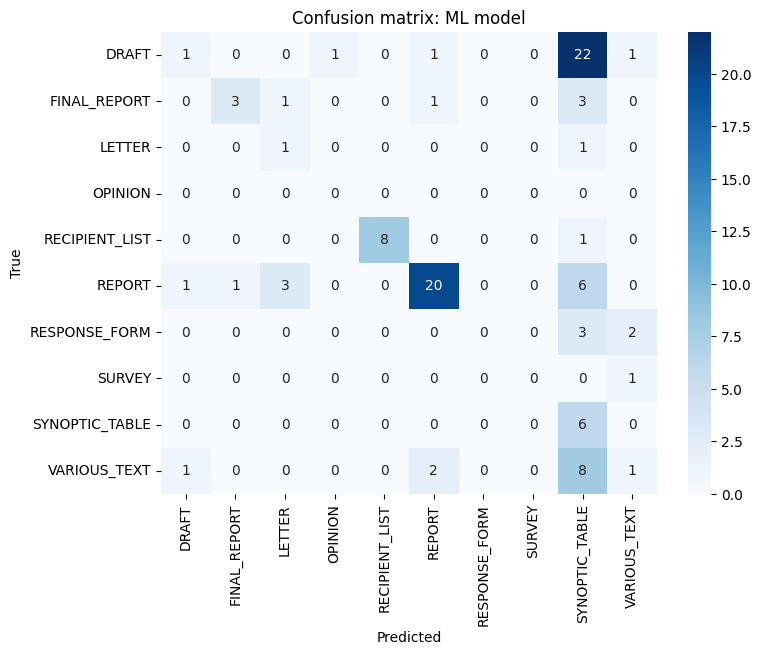

In [47]:
plotting.plot_confusion_matrix_heatmap(
    sample_batch_with_ground_truth["ground_truth"],
    sample_batch_with_ground_truth["prediction_ml"],
    target_names=target_names,
    title="ML model",
    # normalize="true",
)

### Rule-based model vs. ground truth

In [48]:
_df = sample_batch_with_ground_truth[sample_batch_with_ground_truth["prediction_rule"].notna()]
print(sklearn.metrics.classification_report(_df["ground_truth"], _df["prediction_rule"], zero_division=np.nan))

                precision    recall  f1-score   support

         DRAFT       0.77      0.77      0.77        13
  FINAL_REPORT       1.00      0.33      0.50         6
RECIPIENT_LIST       1.00      0.86      0.92         7
        REPORT       0.89      0.85      0.87        20
 RESPONSE_FORM       1.00      0.33      0.50         3
        SURVEY       0.00       nan      0.00         0
SYNOPTIC_TABLE        nan      0.00      0.00         2
  VARIOUS_TEXT       0.25      0.75      0.38         4

      accuracy                           0.71        55
     macro avg       0.70      0.56      0.49        55
  weighted avg       0.85      0.71      0.73        55



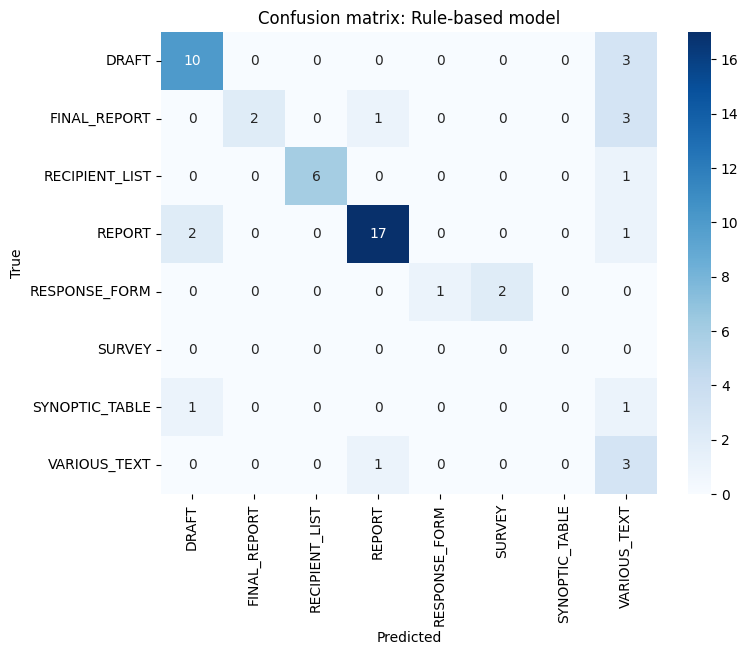

In [51]:
plotting.plot_confusion_matrix_heatmap(
    _df["ground_truth"],
    _df["prediction_rule"],
    target_names=[t for t in target_names if t not in {"OPINION", "LETTER"}],  # TODO: find a cleaner way to do this
    title="Rule-based model",
    # normalize="true",
)

***

# End MLflow run

In [50]:
mlflow.end_run()